In [ ]:
pip install transformers

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import VisualBertForPreTraining, BertTokenizer, VisualBertModel
from transformers import VisualBertConfig

import pickle
import pandas as pd


Définition des classes dont on a besoin

In [3]:
class Model(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.visual_bert = VisualBertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.linear = nn.Linear(config.hidden_size, 1)
        self.attentions = None  # Add an `attentions` attribute to the class

        
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        visual_embeds=None,
        visual_attention_mask=None,
        visual_token_type_ids=None,
    ):
        outputs  = self.visual_bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            visual_embeds=visual_embeds,
            visual_attention_mask=visual_attention_mask,
            visual_token_type_ids=visual_token_type_ids,
            output_attentions=True
        )
        pooled_output = self.dropout(outputs[1])
        linear_output = self.linear(pooled_output)
        output=torch.sigmoid(linear_output)
        attentions = outputs.attentions # extract attention scores from the model outputs

        return output, attentions


In [4]:
# Define the training dataset
class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.indices = list(range(len(data)))  # set indices attribute
        print(self.data.keys())  
        print(f"Number of indices: {len(self.indices)}")


    def __getitem__(self, index):
        index = self.indices[index]  # get the actual index from self.indices
        text = self.data['text'][index]
        label = self.data['label'][index]
        embedded = self.data['embedded'][index]
        
        return text, label, embedded

    def __len__(self):
        return len(self.data)



Chargement du modèle pré entrainé et customisation du modèle

In [122]:
# Define the pre-trained Visual-Bert model

config = VisualBertConfig.from_pretrained('uclanlp/visualbert-nlvr2-coco-pre')
model = Model(config)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [123]:
for layer in model.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()

In [64]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Définition des fonctions d'entrainement et de test

In [108]:
# Define the training loop

def train(model, tokenizer, train_dataset, valid_dataset, optimizer, criterion, device, batch_size, epochs, patience=3, dropout=0.0):
    model.train()
    model.to(device)
    model.dropout = nn.Dropout(dropout)  # add dropout layer with the given dropout probability
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
    best_valid_loss = float('inf')
    patience_count = 0
    for epoch in range(epochs):
        running_loss = 0.0
        running_accuracy = 0.0
        running_TP = 0.0
        running_FP = 0.0
        running_TN = 0.0
        running_FN = 0.0
        for batch in train_loader:
            text, label, embedded = batch
            optimizer.zero_grad()
            text_encoded = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
            text_encoded = {k: v.to(device) for k, v in text_encoded.items()}
            label = label.float().unsqueeze(1).to(device)
            inputs_ids=text_encoded['input_ids'].to(device)
            visual_embeds = embedded.to(device)
            attention_mask = text_encoded['attention_mask'].to(device)
            outputs , attentions = model(input_ids=inputs_ids, attention_mask=attention_mask, visual_embeds=visual_embeds)
            outputs = model.dropout(outputs)  # apply dropout to the model outputs
            loss = criterion(outputs, label)
            loss.backward()
            optimizer.step()
            pred_labels = torch.round(outputs) # round the probabilities to obtain predicted labels
            correct_preds = (pred_labels == label).sum().item() # count the number of correct predictions
            accuracy = correct_preds / batch_size # calculate accuracy
            running_loss += loss.item()
            running_accuracy += accuracy
                
            # Calculate TP, FP, TN, FN
            TP = ((pred_labels == 1) & (label == 1)).sum().item()
            FP = ((pred_labels == 1) & (label == 0)).sum().item()
            TN = ((pred_labels == 0) & (label == 0)).sum().item()
            FN = ((pred_labels == 0) & (label == 1)).sum().item()
            running_TP += TP
            running_FP += FP
            running_TN += TN
            running_FN += FN
       
          
            
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = running_accuracy / len(train_loader)
        epoch_recall = running_TP / (running_TP + running_FN) # recall
        epoch_specificity = running_TN / (running_TN + running_FP) # specificity
        valid_loss = 0.0
        valid_accuracy = 0.0

        for batch in valid_loader:
            text, label, embedded = batch
            text_encoded = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
            text_encoded = {k: v.to(device) for k, v in text_encoded.items()}
            label = label.float().unsqueeze(1).to(device)
            inputs_ids = text_encoded['input_ids'].to(device)
            visual_embeds = embedded.to(device)
            attention_mask = text_encoded['attention_mask'].to(device)
            outputs, attentions = model(input_ids=inputs_ids, attention_mask=attention_mask, visual_embeds=visual_embeds)
            loss = criterion(outputs, label)
            pred_labels = torch.round(outputs) # round the probabilities to obtain predicted labels
            correct_preds = (pred_labels == label).sum().item() # count the number of correct predictions
            accuracy = correct_preds / batch_size # calculate accuracy
            valid_loss += loss.item()
            valid_accuracy += accuracy
          
        valid_loss /= len(valid_loader)
        valid_accuracy /= len(valid_loader)

        print('Epoch [%d] - loss: %.4f - accuracy: %.4f - recall: %.4f - specificity: %.4f - val_loss: %.4f ' % (epoch+1, epoch_loss, epoch_accuracy, epoch_recall, epoch_specificity,  valid_loss))

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            patience_count = 0
        else:
            patience_count += 1
            if patience_count >= patience:
                print("Validation loss did not improve for %d epochs. Training stopped early." % patience)
                break


In [102]:

def test(model, tokenizer, test_dataset, criterion, device, batch_size):
    model.eval()
    model.to(device)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
    running_loss = 0.0
    running_accuracy = 0.0
    running_TP = 0.0
    running_FP = 0.0
    running_TN = 0.0
    running_FN = 0.0
    with torch.no_grad():
        for batch in test_loader:
              text, label, embedded = batch
              text_encoded = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
              text_encoded = {k: v.to(device) for k, v in text_encoded.items()}
              label = label.float().unsqueeze(1).to(device)
              inputs_ids=text_encoded['input_ids'].to(device)
              visual_embeds = embedded.to(device)
              attention_mask = text_encoded['attention_mask'].to(device)
              outputs , attentions = model(input_ids=inputs_ids, attention_mask=attention_mask, visual_embeds=visual_embeds)
              loss = criterion(outputs, label)
              pred_labels = torch.round(outputs) # round the probabilities to obtain predicted labels
              correct_preds = (pred_labels == label).sum().item() # count the number of correct predictions
              accuracy = correct_preds / batch_size # calculate accuracy
              running_loss += loss.item()
              running_accuracy += accuracy

                # Calculate TP, FP, TN, FN
              TP = ((pred_labels == 1) & (label == 1)).sum().item()
              FP = ((pred_labels == 1) & (label == 0)).sum().item()
              TN = ((pred_labels == 0) & (label == 0)).sum().item()
              FN = ((pred_labels == 0) & (label == 1)).sum().item()
              running_TP += TP
              running_FP += FP
              running_TN += TN
              running_FN += FN
                
         
    test_loss = running_loss / len(test_loader)
    test_accuracy = running_accuracy / len(test_loader)
    test_recall = running_TP/ (running_TP + running_FN) # recall
    test_specificity = running_TN / (running_TN + running_FP) # specificity
    print('Test loss: %.4f - Test accuracy: %.4f- recall: %.4f - specificity: %.4f' % (test_loss, test_accuracy,test_recall,test_specificity))


In [115]:

# Define the optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=0.1, weight_decay=0.1)
criterion = nn.BCELoss()


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
df_test=pd.read_json("/content/drive/MyDrive/data/dev.jsonl",lines=True)

m = []

with open(r"/content/drive/MyDrive/data/file_val.pkl","rb") as g:
    m = pickle.load(g)
g.close()
df_test.loc[:, 'embedded'] = m

In [62]:
df_train=pd.read_json("/content/drive/MyDrive/data/train.jsonl",lines=True)

l = []

with open(r"/content/drive/MyDrive/data/file.pkl","rb") as f:
    l = pickle.load(f)
f.close()
df_train.loc[:, 'embedded'] = l

In [65]:
mask_train = pd.to_numeric(df_train['embedded'], errors='coerce').isna()
df_train = df_train[mask_train]
print(len(df_train))

8464


In [86]:
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(df_train, test_size=1000, random_state=42)

# Verify the sizes of the datasets
print(f'Train dataset size: {len(train_df)}')
print(f'Validation dataset size: {len(valid_df)}')

Train dataset size: 7464
Validation dataset size: 1000


In [87]:
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)


In [89]:
train_dataset = MyDataset(train_df)
print(len(train_dataset))
valid_dataset = MyDataset(valid_df)
print(len(valid_dataset))

Index(['id', 'img', 'label', 'text', 'embedded'], dtype='object')
Number of indices: 7464
7464
Index(['id', 'img', 'label', 'text', 'embedded'], dtype='object')
Number of indices: 1000
1000


In [ ]:
train(model, tokenizer, train_dataset, valid_dataset, optimizer, criterion, device, batch_size=16, epochs=10, patience=5, dropout=0.0)

Epoch [1] - loss: 0.6924 - accuracy: 0.5221 - recall: 0.3757 - specificity: 0.6033 - val_loss: 0.6935 
Epoch [2] - loss: 0.6905 - accuracy: 0.5216 - recall: 0.3649 - specificity: 0.6084 - val_loss: 0.6951 
Epoch [3] - loss: 0.6912 - accuracy: 0.5235 - recall: 0.3600 - specificity: 0.6142 - val_loss: 0.6889 
Epoch [4] - loss: 0.6911 - accuracy: 0.5266 - recall: 0.3732 - specificity: 0.6115 - val_loss: 0.6912 
Epoch [5] - loss: 0.6910 - accuracy: 0.5271 - recall: 0.3586 - specificity: 0.6205 - val_loss: 0.6933 
Epoch [6] - loss: 0.6900 - accuracy: 0.5258 - recall: 0.3467 - specificity: 0.6250 - val_loss: 0.6909 


In [97]:
mask_test = pd.to_numeric(df_test['embedded'], errors='coerce').isna()
df_test = df_test[mask_test]
print(len(df_test))

498


In [98]:
df_test = df_test.reset_index(drop=True)


In [99]:
test_dataset = MyDataset(df_test)
print(len(test_dataset))  # should print the length of your train data

Index(['id', 'img', 'label', 'text', 'embedded'], dtype='object')
Number of indices: 498
498


In [ ]:
test(model, tokenizer, test_dataset, criterion, device, batch_size=16)

498
498
AUC-ROC : 0.4824


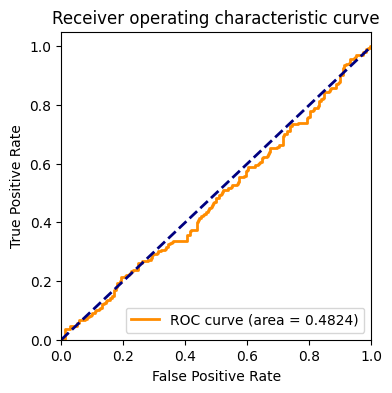

In [111]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score


test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=False)

model.eval()
with torch.no_grad():
    y_pred = []
    y_true = []
   
    for batch in test_loader:
          text, label, embedded = batch
          text_encoded = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
          text_encoded = {k: v.to(device) for k, v in text_encoded.items()}
          label = label.float().unsqueeze(1).to(device)
          inputs_ids=text_encoded['input_ids'].to(device)
          visual_embeds = embedded.to(device)
          attention_mask = text_encoded['attention_mask'].to(device)
          outputs, attentions = model(input_ids=inputs_ids, attention_mask=attention_mask, visual_embeds=visual_embeds)
          outputs_cpu=outputs[0:].cpu()
          label_cpu=label[0:].cpu()
          #print(outputs[0:])
          y_pred.extend(outputs_cpu.numpy())
          y_true.extend(label_cpu.numpy())
          pred_labels = torch.round(outputs[0]) # round the probabilities to obtain predicted labels
          correct_preds = (pred_labels == label).sum().item() # count the number of correct predictions


print(len(y_pred))
print(len(y_true))
# Calculer l'AUC-ROC

auc_roc = roc_auc_score(y_true, y_pred)
print("AUC-ROC : {:.4f}".format(auc_roc))

# Calculer la courbe ROC
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

In [112]:
  model.to(device)
  with torch.no_grad():
  
    for batch in test_loader:
    
              text, label, embedded = batch
              text_encoded = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
              text_encoded = {k: v.to(device) for k, v in text_encoded.items()}
              label = label.float().unsqueeze(1).to(device)
              inputs_ids=text_encoded['input_ids'].to(device)
              visual_embeds = embedded.to(device)
              attention_mask = text_encoded['attention_mask'].to(device)
              outputs, attentions = model(input_ids=inputs_ids, attention_mask=attention_mask, visual_embeds=visual_embeds)
     

              # Extraire les scores d'attention par couche
              #attentions = outputs.attentions
              for layer, attention in enumerate(attentions):
                print(f"Layer {layer+1} attention shape: {attention.shape}")
              # Extraire les scores d'attention par tête et par couche
              #multi_head_attention = outputs.multi_head_attention_outputs
              #for layer, attention_layer in enumerate(multi_head_attention):
                 #print(f"Layer {layer+1} attention shape: {[attention.shape for attention in attention_layer]}")
              



Layer 1 attention shape: torch.Size([32, 12, 131, 131])
Layer 2 attention shape: torch.Size([32, 12, 131, 131])
Layer 3 attention shape: torch.Size([32, 12, 131, 131])
Layer 4 attention shape: torch.Size([32, 12, 131, 131])
Layer 5 attention shape: torch.Size([32, 12, 131, 131])
Layer 6 attention shape: torch.Size([32, 12, 131, 131])
Layer 7 attention shape: torch.Size([32, 12, 131, 131])
Layer 8 attention shape: torch.Size([32, 12, 131, 131])
Layer 9 attention shape: torch.Size([32, 12, 131, 131])
Layer 10 attention shape: torch.Size([32, 12, 131, 131])
Layer 11 attention shape: torch.Size([32, 12, 131, 131])
Layer 12 attention shape: torch.Size([32, 12, 131, 131])
Layer 1 attention shape: torch.Size([32, 12, 143, 143])
Layer 2 attention shape: torch.Size([32, 12, 143, 143])
Layer 3 attention shape: torch.Size([32, 12, 143, 143])
Layer 4 attention shape: torch.Size([32, 12, 143, 143])
Layer 5 attention shape: torch.Size([32, 12, 143, 143])
Layer 6 attention shape: torch.Size([32, 12, 

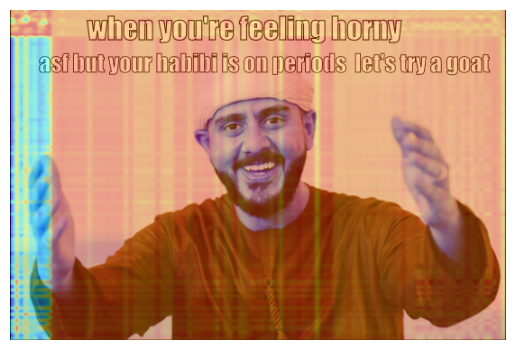

In [113]:
import matplotlib.pyplot as plt
import numpy as np
import cv2


test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=False)
for batch in test_loader  : 

  # Load the image


    text, label, embedded = batch
    text_encoded = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    text_encoded = {k: v.to(device) for k, v in text_encoded.items()}
    label = label.float().unsqueeze(1).to(device)
    inputs_ids=text_encoded['input_ids'].to(device)
    visual_embeds = embedded.to(device)
    attention_mask = text_encoded['attention_mask'].to(device)
    outputs, attentions = model(input_ids=inputs_ids, attention_mask=attention_mask, visual_embeds=visual_embeds)
    break
  #Resize the image to match the input size of the model
  #img = cv2.resize(img, (224, 224))
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_path = df_test['img'][1]
path='/content/drive/MyDrive/data/'+img_path
#img = cv2.imread('/content/drive/MyDrive/data/'+img_path)
img= cv2.imread('/content/drive/MyDrive/data/img/01235.png')
# Get the attention scores for the image
attention_scores = attentions[0][0][0].detach().cpu().numpy()

attention_scores = cv2.resize(attention_scores, (img.shape[1], img.shape[0]))
attention_scores = (attention_scores - attention_scores.min()) / (attention_scores.max() - attention_scores.min())
heatmap = cv2.applyColorMap(np.uint8(255*attention_scores), cv2.COLORMAP_JET)

result = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

plt.imshow(result)
plt.axis('off')
plt.show()
